# CSS Lab: Social Rank and Hierarchy
Network analysis can be used to examine social status within a community. This lab will use data from the 1995-1997 Teenage Friends and Lifestyle study [MA1997]. This study collected friendship and other data from a group of teenage students over the course of three years.

## Contents
1. [Setup](#Setup)
2. [Social status](#Social-status)
    1. [Minimum violation rankings](#Minimum-violation-rankings)
3. [Directed social network](#Directed-social-network:-TFLS)
    2. [Minimum violation rankings for TFLS](#Minimum-violation-rankings-for-TFLS)
3. [Approximate MVRs](#Approximate-MVRs)
    4. [Compare approximations](#Compare-approximations)
        1. [In-Degree](#In-Degree)
        2. [PageRank](#PageRank)
        3. [SpringRank](#SpringRank)
    4. [Choose an approximation](#Choose-an-approximation)
5. [Analyze friendships](#Analyze-friendships)
6. [Time evolution](#Time-evolution)
    1. [Changes in social status](#Changes-in-social-status)
    2. [Changes over multiple years](#Changes-over-multiple-years)
    3. [Stability of social status](#Stability-of-social-status)
    4. [Social status and communities](#Social-status-and-communities)
7. [Behavioral data](#Behavioral-data)
    1. [Examine individual participants](#Examine-individual-participants)
    2. [Correlations with social status](#Correlations-with-social-status)
    3. [Correlations with change in social status](#Correlations-with-change-in-social-status)
    4. [Multiple regression](#Multiple-regression)
    5. [Gender differences](#Gender-differences)
    6. [Gender differences: multiple regression](#Gender-differences:-multiple-regression)
    7. [Gender differences: methods comparison](#Gender-differences:-methods-comparison)
8. [Try it yourself](#Try-it-yourself)
9. [References](#References)
    

## Setup

In [1]:
%pylab inline
import itertools
import json
import math
import sys
import time
import urllib.request
import networkx as nx
import networkx.algorithms as nxalg
import networkx.algorithms.community as nxcom
import networkx.readwrite as nxrw
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as spstats
import statsmodels.api as sm
import visJS2jupyter.visJS_module as vjs
import re
from springrank.SpringRank_tools import SpringRank
from springrank.tools import build_graph_from_adjacency


Populating the interactive namespace from numpy and matplotlib


/Users/elplatt/science3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Helper functions

def load_tfls(wave=1):
    G = nx.DiGraph()
    with open("external/TFLS/friendship-{}.csv".format(wave)) as f:
        # Read header
        labels = re.split(",", f.readline().strip())[1:]
        labels = [x.strip('"') for x in labels]
        # Read data
        for row, row_data in enumerate(f):
            cells = re.split(",", row_data.strip())
            row_label = cells[0].strip('"')
            cells = cells[1:]
            for col, cell_data in enumerate(cells):
                if row_label == labels[col]:
                    continue
                if cell_data == "1" or cell_data == "2":
                    cell_data = 1
                    G.add_edge(row_label, labels[col], weight=cell_data, value=cell_data)
    nx.set_node_attributes(G, dict((v, v) for v in G.nodes()), name="label")
    return G

def get_colors():
    phi = (1 + math.sqrt(5)) / 2
    color = []
    span = 0.5
    low = 0.4
    offset = 0.5
    N = 16
    H = 5
    L = math.ceil(N / H)
    for i in range(N):
        level = (i - i % H) / H
        t = phi * (i + 1) + offset
        t = t - math.floor(t)
        l = (L - level) / L
        y = round(255 * (l * (low + span * t)))
        b = round(255 * (l * (low + span * (1.0 - t))))
        color.append((y, y, b))
    return color

# Standard but not colorblind-safe categorical colors
c20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
    (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
    (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
    (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
    (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

def visualize_visjs(
        G, communities=None, colors=None, safe_colors=True, default_color="192,192,192",
        node_size_field="node_size", layout="spring", scale=500, pos=None,
        groups=None, smooth=False, weight=None, labels=None, title="",
        shadow=True, shape="dot", node_colors=None, node_alpha=None, edge_alpha=None,
        edge_colors=None):
    # Defaults
    if labels is None:
        labels = dict()
    if node_colors is None:
        node_colors = dict()
    if node_alpha is None:
        node_alpha = dict()
    if edge_alpha is None:
        edge_alpha = dict()
    if edge_colors is None:
        edge_colors = dict()
    # Get list of nodes and edges
    nodes = list(G.nodes())
    edges = list(G.edges())
    # Change node shapes for bipartite graph
    if groups is None:
        node_shapes = dict()
        node_sizes = dict()
    else:
        node_shapes = dict((n, "square") for n in groups)
        node_sizes = dict((n, 15) for n in groups)
        node_colors = dict((n, "192,128,0") for n in groups)
    # Per-node properties
    nodes_dict = dict((n, {
        "id": str(labels.get(n, n)),
        "node_size": node_sizes.get(n, 5),
        "node_shape": node_shapes.get(n, shape),
        "border_width": 2,
        "color": "rgba({},{})".format(node_colors.get(n, default_color), node_alpha.get(n, 1.0))
        }) for n in nodes)
    if shape == "cat":
        for key, node in nodes_dict.items():
            node["node_shape"] = "image"
            node["node_image"] = "cat.png"
    # Generate a layout for the nodes
    edge_smooth_enabled = smooth
    edge_width = 4
    edge_arrow_scale = 1
    if communities is not None and pos is None:
        # Generate initial positions based on community
        phi = 3.14 / len(nodes)
        community_node = []
        # Create list of nodes and their communities
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                community_node.append((i, node))
        # Sort by community and
        community_node = sorted(community_node)
        # Generate initial position by placing communities around a circle
        pos = dict((d[1], (math.cos(i*phi), math.sin(i*phi))) for i, d in enumerate(community_node))
    if layout == "circle":
        pos = nx.circular_layout(G, scale=scale)
    elif layout == "spring":
        try:
            GU = G.to_undirected()
        except AttributeError:
            GU = G
        pos = nx.spring_layout(GU, k=3/math.sqrt(len(nodes)), scale=scale, pos=pos)
    # Assign position
    for n in nodes:
        nodes_dict[n]["x"] = pos[n][0]
        nodes_dict[n]["y"] = pos[n][1]
    # Calculate bounds for scaling
    x_min = min(pos.values(), key=lambda x: x[0])[0]
    x_max = max(pos.values(), key=lambda x: x[0])[0]
    y_min = min(pos.values(), key=lambda x: x[1])[1]
    y_max = max(pos.values(), key=lambda x: x[1])[1]
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    # If we have communities, assign color based on community
    if colors is None:
        if safe_colors:
            colors = ["{},{},{}".format(*c) for c in get_colors()]
        else:
            colors = ["{},{},{}".format(*c) for c in c20]
    if communities is not None:
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                try:
                    nodes_dict[node]["color"] = "rgba({},{})".format(colors[i], node_alpha.get(node, 1.0))
                    nodes_dict[node]["color_index"] = i
                except IndexError:
                    nodes_dict[node]["color"] = "rgba({},{})".format(default_color, node_alpha.get(node, 1.0))
    # Update color for bipartite nodes
    for node, node_attr in nodes_dict.items():
        if node in node_colors:
            node_attr["color"] = "rgba({},{})".format(node_colors.get(node, default_color), node_alpha.get(node, 1.0))
    # Map node labels to contiguous ids
    node_map = dict(zip(nodes,range(len(nodes))))
    # Determine edge colors
    edge_colors_idx = {}
    for source, target in edges:
        source_color = nodes_dict[source].get("color_index", None)
        target_color = nodes_dict[target].get("color_index", None)
        if source_color == target_color and source_color is not None:
            edge_colors_idx[(source, target)] = source_color
    for e, c in edge_colors_idx.items():
        if c < len(colors) and e not in edge_colors:
            edge_colors[e] = colors[c]
    # Per-edge properties, use contiguous ids to identify nodes
    edge_scale = math.ceil(max_range / 200)
    edges_dict = []
    for source, target, data in G.edges(data=True):
        edge = {
            "source": node_map[source],
            "target": node_map[target],
            "title":'test',
            "color": "rgba({},{})".format(edge_colors.get((source,target), default_color), edge_alpha.get((source,target), 0.5)),
            "edge_width_field": "value",
            "value": data.get("value", 1) * edge_scale
        }
        edges_dict.append(edge)
    # Convert nodes dict to node list
    nodes_list = [nodes_dict[n] for n in nodes]
    # Check for directed graph
    if G.__class__ == nx.classes.digraph.DiGraph:
        directed = True
    else:
        directed = False
    # Call visjs
    return vjs.visjs_network(
        nodes_list, edges_dict,
        node_size_field="node_size",
        node_size_multiplier=10.0,
        node_shadow_enabled=shadow,
        node_color_border="rgba(0,0,0,{})".format(1.0),
        edge_width_field="value",
        edge_width=edge_width,
        edge_arrow_to=directed,
        edge_arrow_to_scale_factor=edge_arrow_scale,
        edge_smooth_enabled=edge_smooth_enabled,
        edge_smooth_type="curvedCW",
        graph_id=hash(title))

## 1. Social status
When members of a social group can be ordered in terms of social status, it forms a pecking order. Directed network data can be used to uncover an underlying pecking order if it exists. An unreciprocated friendship can be a sign of a difference in social standing. The person who doesn't list the friendship may do so because they have too many friends to list, or because they don't want to list someone unpopular.

### Minimum violation rankings
In a perfect pecking order, friendships would only go from lower-status nodes to higher-status nodes.
So to find a pecking order, we look for a _minimum-violation ranking_: an ordering with as few links going from high-status to low-status individuals as possible.
Such an ordering may or may not exist.
The more violoations in the MVR, the less heirarchical a group is.
The example below allows you to test different orderings for the number of violations.

First, visualize the network.

In [3]:
# Helper functions 

def scale(x):
    return (x - np.mean(x)) / np.std(x)

def unit(rank):
    v = rank.values()
    span = max(v) - min(v)
    return dict((k, (x - min(v)) / span) for k, x in rank.items())

def giant_component(G):
    giant_component = sorted(nxalg.weakly_connected_components(G), reverse=True, key=len)[0]
    for v in set(G.nodes()) - giant_component:
        G.remove_node(v)
    return G

def get_mvr_rank(G, time_limit=60):
    # Iterative implementation to test all configurations
    labels = list(G.nodes())
    N = len(labels)
    ranking = []
    # Lists of remaining labels once i places have been assigned
    remaining = [[] for i in range(N)]
    remaining[0] = list(labels)
    # Upper limit is all pairs
    best_violations = N * (N - 1) / 2
    best_ranking = []
    start = time.time()
    last = start
    i = 0
    tried = 0
    while True:
        i += 1
        # Check for time limit, and sleep periodically to avoid locking cpu
        if i % 1000 == 0:
            t = time.time()
            delta = t - start
            if delta >= time_limit:
                print("Time limit exceeded")
                print("{} of {:0.2e} configurations in {:0.2f}s".format(i, math.factorial(N), delta))
                raise RuntimeError
            time.sleep(0)
        try:
            # Assign the next remaining label to the current place and move to the next
            ranking.append(remaining[len(ranking)].pop())
            if len(ranking) == N:
                # Out of places, compare the full assignment to the best so far
                trial_ranking = dict((label, i) for i, label in enumerate(ranking))
                rank_differences, violations, reciprocated = count_violations(G, trial_ranking)
                if violations < best_violations:
                    best_violations = violations
                    best_ranking = trial_ranking
                tried += 1
                # Backtrack
                ranking.pop()
            else:
                # Move to next place
                remaining[len(ranking)] = list(set(labels) - set(ranking))
        except IndexError:
            # No labels remaining, backtrack
            try:
                ranking.pop()
            except IndexError:
                # Unable to backtrack, all labels have been tried for all places
                break
    best_order = dict((x, N - i) for x, i in best_ranking.items())
    return best_ranking, best_order

def get_spring_rank(G):
    nodes = list(G.nodes())
    A=nx.to_numpy_matrix(G,nodelist=list(nodes))
    # Reverse spring rank so positive numbers represent higher status
    rank = dict(zip(nodes, -1 * SpringRank(A,alpha=0.0,l0=1.0,l1=1.0)))
    order = dict((elt[0], i) for i, elt in enumerate(sorted(rank.items(), key=lambda x: x[1])))
    return rank, order

def get_degree_rank(G):
    all_nodes = set(G.nodes())
    rank = dict((v, G.in_degree(v)) for v in all_nodes)
    order = dict((elt[0], i) for i, elt in enumerate(sorted(rank.items(), key=lambda x: x[1])))
    return rank, order

def get_pagerank(G):
    rank = nx.pagerank(G)
    order = dict((elt[0], i) for i, elt in enumerate(sorted(rank.items(), key=lambda x: x[1])))
    return rank, order

def count_violations(G, order):
    rank_differences = []
    violations = 0
    reciprocated = []
    all_edges = list(G.edges())
    for v, w in G.edges():
        if (w, v) in all_edges:
            reciprocated.append(True)
        else:
            reciprocated.append(False)
        difference = order[w] - order[v]
        rank_differences.append(difference)
        if difference < 0:
            violations += 1
    return rank_differences, violations, reciprocated
    
def plot_ordering(G, rank, title="Ordering", scale=150, shape="dot"):
    nodes = list(G.nodes())
    pos = dict((v, (0, r*scale)) for v, r in unit(rank).items())
    return visualize_visjs(G, layout=None, smooth=True, pos=pos, scale=scale, title=title, shape=shape)

def plot_orderings(Gs, ranks, title="Ordering", connect=False, scale=150, shape="dot", node_alpha=dict()):
    pos = dict()
    H = nx.DiGraph()
    all_nodes = set()
    for G in Gs:
        all_nodes |= set(G.nodes())
    for i, rank in enumerate(ranks):
        rank = unit(rank)
        GG = Gs[i]
        GG.add_nodes_from(all_nodes)
        new_labels = dict((v, "{}-{}".format(v, i)) for v in all_nodes)
        GG = nx.relabel.relabel_nodes(GG, new_labels)
        # Reverse y axis so higher rank is up
        pos_i = dict((new_labels[v], (i*scale, -1*r*scale)) for v, r in rank.items())
        pos.update(pos_i)
        H = nx.compose(H, GG)
    if connect:
        for i in range(len(ranks) - 1):
            for v in nodes:
                H.add_edge("{}-{}".format(v, i), "{}-{}".format(v, i+1))
    return visualize_visjs(H, layout=None, smooth=True, pos=pos, scale=scale, title=title, shape=shape, node_alpha=node_alpha, shadow=False)

def mvr_example():
    H = nx.DiGraph()
    H.add_edges_from([
        ('Lemon', 'Cotton'),
        ('Mia', 'Cotton'),
        ('Mia', 'Lemon'),
        ('Mia', 'Bagel'),
        ('Lemon', 'Bagel'),
        ('Setzer', 'Cotton'),
        ('Lemon', 'Setzer')
    ])
    return H

def get_communities(G):
    communities = nx.algorithms.community.greedy_modularity_communities(G.to_undirected())
    community = sorted(communities, key=len, reverse=True)
    all_nodes = list(G.nodes())
    df = pd.DataFrame(index=all_nodes)
    for i, com in enumerate(communities):
        key = "in_community{:02d}".format(i)
        values = dict((v, int(v in com)) for v in all_nodes)
        col_df = pd.DataFrame({key:values}, index=all_nodes)
        df = pd.concat([df, col_df], axis=1)
    return df

In [5]:
G_example = mvr_example()
visualize_visjs(G_example, shape="cat", scale = 250, title="MVR Example Network")

Next, let's define an ordering, visualize it, and count the number of violations. In the visualization below, the nodes are drawn from top (highest status) to bottom (lowest status).

In [6]:
# To re-order the nodes, change these numbers
mvr_order = {
    "Bagel":  0,
    "Cotton": 1,
    "Lemon":  2,
    "Mia":    3,
    "Setzer": 4
}
# Count the violations and visualize
rank_differences, violations, reciprocated = count_violations(G_example, mvr_order)
print("Violations:", violations)
plot_ordering(G_example, mvr_order, scale=500, shape="cat", title="MVR Example")

Violations: 6


### Short Answer Q1
In the interactive plot above, try moving the nodes around to find the fewest number of violations you can. When you've found your best order, you can change the order in the cell above and re-run the visualization. In the visualization, which direction do edges point if they are violations? What is the fewest number of violations you could find? What is the corresponding order?

Now let's see the actual minimum violation ranking.

In [7]:
mvr_score, mvr_order = get_mvr_rank(G_example)
for label, rank in sorted(mvr_order.items(), key=lambda x: x[1]):
    print("Place {}: {}".format(rank, label))

Place 1: Bagel
Place 2: Cotton
Place 3: Setzer
Place 4: Lemon
Place 5: Mia


The network above has a ranking with no violations. However, in real networks, it is uncommon to have a ranking with no violations, which is why the _minimum_ violation ranking is used.

## Directed social network: TFLS
Now we'll load and visualize friendship data from a real social network. The [MA1997] study determined friendships by asking participants to name their top friends. This method has in interesting feature: it is possible for a participant to list someone as a friend who does not list the participant as a friend. The friendship ties are _directed_. In the visualization, arrows go from the participant to the individuals they named as friends. Reciprocated friendships have arrows on both ends. The nodes and edges are also colored based on the results of a community-detection algorithm. By default, the visualization uses a colorblind-safe palette (approximately 4% of people have some form of colorblindness). If you change `safe_colors` to `False`, colors will be more distinguishable for people with full color vision.

Study participants were asked to name up to 12 friends.

In [ ]:
G_tfls = load_tfls()
communities = nx.algorithms.community.greedy_modularity_communities(G_tfls.to_undirected())
visualize_visjs(G_tfls, scale=2500, title="Full Network", communities=communities, safe_colors=False)

### Minimum violation ranking for TFLS
Now let's try to find the minimum violation ranking for the Teen Friendship and Lifestyle Study. The data set is much larger than the previous example, so it may take longer to run. If it takes longer than one minute to find an MVR, the function will exit with an error message.

In [9]:
try:
    mvr_score, mvr_order = get_mvr_rank(G_tfls)
except RuntimeError:
    pass

Time limit exceeded
38000 of 2.01e+269 configurations in 61.01s


### Short Answer Q2
Did the code above complete in less than a minute? If not, use the output of the error message to answer the following. How many possible configurations are there (note: in python, large numbers are written like 6.022e+23, which means 6.022 multiplied by 10 to the 23rd power)? How long would the algorithm have taken to complete? How does that compare to the age of the universe (4.3e+23 seconds)?

### Approximate MVRs

We'd like to find the MVR. Unfortunately, as we've seen above, finding the MVR is very difficult even with a lot of computing power (in computer science terms, it's NP-hard).
Luckily, approximation methods exist that can run much faster. These methods find a low violation ranking but are not guaranteed to find the true minimum violation ranking.

The example below explores some possible approximations. PageRank (used by Google's search engine) gives nodes higher scores for being connected to well-connected nodes. SpringRank [BLN2013] is specifically designed to find approximate MVRs. Each assigns a score to nodes, and then nodes are ranked according to that value. The visualization below shows (from left to right) eigenvector centrality, PageRank, and SpringRank. Higher nodes have higher scores, and arrows pointing downward represent violations.

In [ ]:
# Calculate the rank
dr_score, dr_order = get_degree_rank(G_tfls)
pr_score, pr_order = get_pagerank(G_tfls)
sr_score, sr_order = get_spring_rank(G_tfls)
# Plot the orderings
plot_orderings([G_tfls, G_tfls, G_tfls], [dr_score, pr_score, sr_score], title="MVR Examples", scale=2000)

### Compare approximations
The cells below count violations for rankings based on Degree, PageRank, and SpringRank.

#### In-Degree

In [11]:
dr_differences, dr_violations, dr_reciprocated = count_violations(G_tfls, dr_order)
print("Violations:", dr_violations)
print("Violation percent:", dr_violations / len(list(G_tfls.edges())))
print("Mean rank difference:", np.mean(dr_differences))

Violations: 219
Violation percent: 0.37372013651877134
Mean rank difference: 18.7849829352


#### PageRank

In [12]:
pr_differences, pr_violations, pr_reciprocated = count_violations(G_tfls, pr_order)
print("Violations:", pr_violations)
print("Violation percent:", pr_violations / len(list(G_tfls.edges())))
print("Mean rank difference:", np.mean(pr_differences))

Violations: 221
Violation percent: 0.3771331058020478
Mean rank difference: 17.3788395904


#### SpringRank

In [13]:
sr_differences, sr_violations, sr_reciprocated = count_violations(G_tfls, sr_order)
print("Violations:", sr_violations)
print("Violation percent:", sr_violations / len(list(G_tfls.edges())))
print("Mean rank difference:", np.mean(sr_differences))

Violations: 187
Violation percent: 0.3191126279863481
Mean rank difference: 18.9470989761


Now let's see how highly correlated different scoring methods are. Each row/column below represents one scoring method. The off-diagonal squares plot different methods against each other, while the diagonals show histograms for each method.

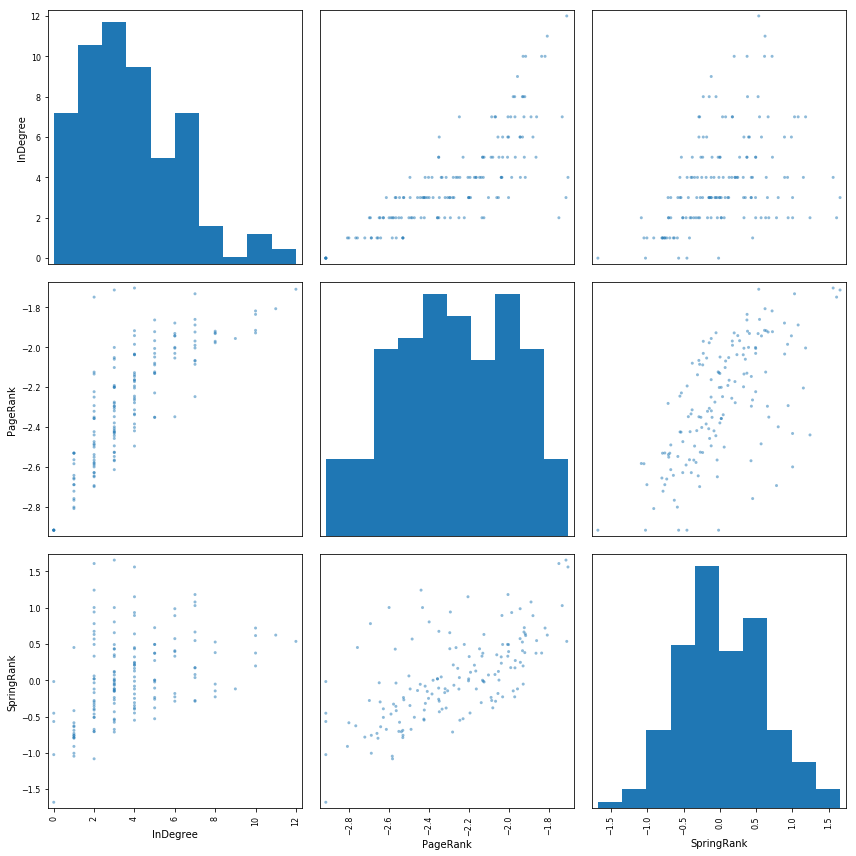

In [14]:
df = pd.DataFrame({
    "InDegree": dr_score,
    "PageRank": pr_score,
    "SpringRank": sr_score
})
df["PageRank"] = np.log10(df["PageRank"])
pd.plotting.scatter_matrix(df, figsize=(12,12))
plt.tight_layout()

### Short Answer Q3
Which approximation method gave the lowest number of violations? What percentage of edges violated the best MVR approximation? If the network is very hierarchical, there should be close to 0 violations, how hierarchical is this network?

### Choose an approximation method
In the cell below, select one of the scoring methods to use for the rest of the lab.

In [15]:
#method = "InDegree"
#method = "PageRank"
method = "SpringRank"

if method == "InDegree":
    order_differences, violations, reciprocated, get_rank = dr_differences, dr_violations, dr_reciprocated, get_degree_rank
elif method == "PageRank":
    order_differences, violations, reciprocated, get_rank = pr_differences, pr_violations, pr_reciprocated, get_pagerank
elif method == "SpringRank":
    order_differences, violations, reciprocated, get_rank = sr_differences, sr_violations, sr_reciprocated, get_spring_rank

### Analyze friendships

We might wonder wehther people include high or low status individuals when they list their friends. The plot below shows a histogram of the social status order differences for each friendship. Positive numbers represent someone listing a friend who has higher social status than they do.

In [16]:
# Helper functions

def plot_reciprocated(df):
    rows = df["reciprocated"]
    low = min(df["difference"])
    high = max(df["difference"])
    span = high - low + 1
    nbins = 10
    per = span / nbins
    x = []
    y = []
    err = []
    for i in range(nbins):
        l = round(low + i*per)
        h = round(low + ((i+1)*per))
        dfbin = df[(df["difference"] >= l) & (df["difference"] < h)]
        N_recip = len(dfbin[dfbin["reciprocated"] == True])
        N_unrecip = len(dfbin[dfbin["reciprocated"] == False])
        x.append(round((l + h) / 2))
        y.append(N_recip / (N_recip + N_unrecip))
        err.append(2/math.sqrt(N_recip + N_unrecip))
    x = np.array(x)
    err = np.array(err)
    f = plt.figure()
    plt.plot(x, y)
    plt.fill_between(x, y - err, y + err, color="lightblue")
    plt.ylim([0,1])
    plt.tight_layout()
    plt.xlabel("Friend's status difference")
    plt.ylabel("Fraction reciprocated")
    plt.xlim([-50, 100])

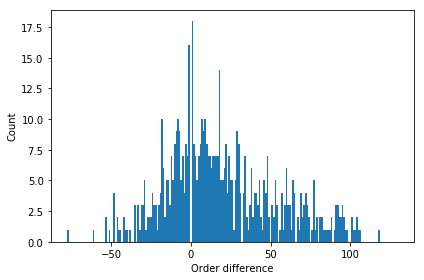

In [17]:
bins = np.arange(min(order_differences) - 0.5, max(order_differences) + 0.5)
plt.hist(order_differences, bins=bins)
xlabel("Order difference"); ylabel("Count");
plt.tight_layout()

We are using unreciprocated friendships as an indicator of social status, so an individual's friendships should be more likely to be reciprocted when they are with lower-status individuals. To confirm, the figure below shows the fraction of friendships that are reciprocated based on status difference. Positive status difference represent lower status individuals reporting friendships with higher status individuals.

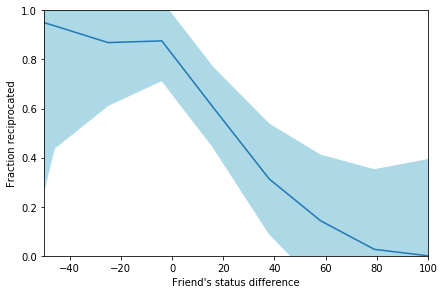

In [18]:
df = pd.DataFrame({"difference": order_differences, "reciprocated": reciprocated})
plot_reciprocated(df)

### Short Answer Q4
In the plot above, the line shows how often friendships are reciprocated as a function of status difference (the shaded area represents statistical uncertainty). How well does the plot confirm our hypothesis that higher status friendships are less likely to be reciprocated?

### Time evolution
The TFLS study surveyed participants three years in a row. These multiple measurements make it possible to analyze the change in the social network over time.

In [19]:
# Helper functions
def gradient(x):
    y = math.floor(128 - x*64)
    b = math.floor(128 + x*64)
    return "{},{},{}".format(y, y, b)

def get_deltas(Gs, scores):
    scores = list(scores)
    deltas = []
    orders = []
    for i, score in enumerate(scores):
        # Scale to range [0,1]
        scores[i] = unit(score)
        # Calculate orders (small is low status)
        orders.append(
            dict((elt[0], i)
            for i, elt in enumerate(sorted(scores[i].items(), key=lambda x: x[1]))))
    # Add scores to DataFrame
    for i in range(0, len(scores)):
        label = []
        delta = []
        score = []
        order = []
        new_score = []
        for v, node_score in scores[i].items():
            # Calculate change and scale to (-1, 1)
            label.append(v)
            score.append(node_score)
            order.append(orders[i][v])
        df = pd.DataFrame({
            "label":label,
            "score_{}".format(i): score,
            "order_{}".format(i): order})
        df = df.set_index("label")
        deltas.append(df)
    # Add score changes to DataFrame
    for i in range(1, len(scores)):
        label = []
        delta = []
        order_delta = []
        for v, new_score in scores[i].items():
            # Calculate change and scale to (-1, 1)
            label.append(v)
            old_score = scores[i-1][v]
            delta.append((new_score - old_score) / 2.0)
            old_order = orders[i-1][v]
            new_order = orders[i][v]
            order_delta.append(new_order - old_order)
        df = pd.DataFrame({
            "label":label,
            "score_delta_{}".format(i): delta,
            "order_delta_{}".format(i): order_delta})
        df = df.set_index("label")
        deltas.append(df)
    # Calculate similarity between old and new communities
    all_nodes = set()
    community_t = [nx.algorithms.community.greedy_modularity_communities(x.to_undirected()) for x in Gs]
    node_community = [{}, {}, {}]
    for t, communities in enumerate(community_t):
        for i, com in enumerate(communities):
            for v in com:
                node_community[t][v] = i
                all_nodes.add(v)
    all_nodes = sorted(all_nodes)
    for t in range(len(community_t) - 1):
        similarity = []
        for v in all_nodes:
            current_com = set(community_t[t][node_community[t][v]])
            next_com = set(community_t[t+1][node_community[t+1][v]])
            s = len(current_com & next_com) / len(current_com | next_com)
            similarity.append(s)
        df = pd.DataFrame({
            "label": all_nodes,
            "community_sim_{}".format(t): similarity
        }).set_index("label")
        deltas.append(df)
    return pd.concat(deltas, axis=1)
    
def plot_ordering_evolution(Gs, ranks, title="Ordering", scale=150, shape="dot"):
    pos = dict()
    H = nx.DiGraph()
    all_nodes = set()
    node_colors = {}
    edge_colors = {}
    edge_alpha = {}
    for i, rank in enumerate(ranks):
        ranks[i] = unit(rank)
    for G in Gs:
        all_nodes |= set(G.nodes())
    for i, rank in enumerate(ranks):
        GG = Gs[i].copy()
        GG.remove_edges_from(list(GG.edges()))
        GG.add_nodes_from(all_nodes)
        new_labels = dict((v, "{}-{}".format(v, i)) for v in all_nodes)
        GG = nx.relabel.relabel_nodes(GG, new_labels)
        pos_i = dict((new_labels[v], (i*scale, r*scale)) for v, r in rank.items())
        pos.update(pos_i)
        H = nx.compose(H, GG)
    for i in range(1, len(ranks)):
        for v, new_rank in ranks[i].items():
            # Calculate change and scale to (-1, 1)
            old_label = "{}-{}".format(v, i-1)
            label = "{}-{}".format(v, i)
            delta = (new_rank - ranks[i-1][v])
            color = gradient(delta)
            alpha = abs(new_rank - ranks[i-1][v])
            node_colors[label] = color
            if old_label in H and label in H:
                H.add_edge(old_label, label)
                edge_colors[(old_label, label)] = color
                edge_alpha[(old_label, label)] = alpha
    node_alpha = dict((v, 0.5) for v in H.nodes())
    return visualize_visjs(
        H, scale=scale, layout=None, pos=pos,
        shape=shape, node_colors=node_colors, node_alpha=node_alpha, shadow=False,
        edge_colors=edge_colors, edge_alpha=edge_alpha,
        title=title)

def print_evolution(label, G, score_t, order_t):
    print("Participant {}".format(label))
    for i, H in enumerate(G):
        orders_in = sorted([str(order_t[i][v]) for v in H.predecessors(label)])
        orders_out = sorted([str(order_t[i][v]) for v in H.successors(label)])
        print("Year {}".format(i+1))
        label_t = "{}-{}".format(label, i)
        print("\tIn-Degree: ", H.in_degree(label), " Friends' status: {}".format(", ".join(orders_in)))
        print("\tOut-Degree: ", H.out_degree(label), " Friends' status: {}".format(", ".join(orders_out)))
        print("\tScore: {:0.2f}".format(score_t[i][label]))
        print("\tOrder: ", order_t[i][label])

#### Change in social status
The plot below shows the social status of each participant in each year, with time increasing to the right
and status increasing upward.
Arrows are drawn from each node to its place in the next year.
Participants who move up in status are represented by yellow nodes/arrows, and participants who move down are represented by blue.

In [ ]:
score_t = []
order_t = []
G = []
all_nodes = set()
for wave in range(3):
    G.append(load_tfls(wave+1))
    all_nodes |= set(G[wave].nodes())
for wave in range(3):
    G[wave].add_nodes_from(all_nodes)
    score, order = get_rank(G[wave])
    score_t.append(score)
    order_t.append(order)
# Plot the orderings
plot_ordering_evolution(G, score_t, title="Rank Over Time", scale=1000)

Why do individuals move up or down in status? You can use the cell below to examine how an individual's network changes over time. You can change the label parameter to examine different participants.

In [21]:
print_evolution('s001', G, score_t, order_t)

Participant s001
Year 1
	In-Degree:  2  Friends' status: 19, 27
	Out-Degree:  2  Friends' status: 128, 27
	Score: 0.42
	Order:  47
Year 2
	In-Degree:  3  Friends' status: 49, 60, 68
	Out-Degree:  3  Friends' status: 103, 49, 68
	Score: 0.46
	Order:  63
Year 3
	In-Degree:  3  Friends' status: 11, 5, 7
	Out-Degree:  4  Friends' status: 104, 11, 5, 7
	Score: 0.20
	Order:  9


#### Changes over multiple years
We might ask whether individuals who move to higher status continue to do so, or do they move back towards their original position. The cell below compares the change in social status between years 1 and 2 to the change between years 2 and 3.

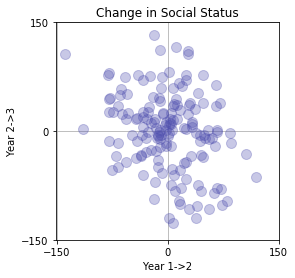

In [22]:
deltas = get_deltas(G, order_t)
plt.figure(figsize=(4,4))
plt.plot(deltas["order_delta_1"], deltas["order_delta_2"], '.', markersize=20, color="#4F4FAF4F")
plt.title("Change in Social Status")
plt.xlabel("Year 1->2"); plt.ylabel("Year 2->3")
plt.xticks([-150, 0, 150])
plt.yticks([-150, 0, 150])
plt.grid()
# Same axis, explain status direction

#### Stability of social status
Is social status more stable at different levels? The cell below visualizes the change in status between years 1 and 2 as a function of the year 1 status.

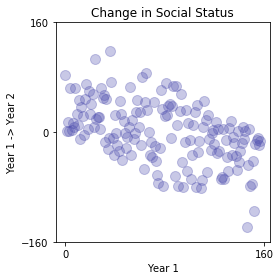

In [23]:
plt.figure(figsize=(4,4))
plt.plot(deltas["order_0"], deltas["order_delta_1"], '.', markersize=20, color="#4F4FAF4F")
plt.title("Change in Social Status")
plt.xlabel("Year 1"); plt.ylabel("Year 1 -> Year 2")
plt.xticks([0, 160])
plt.ylim([-160, 160])
plt.yticks([-160, 0, 160])
plt.tight_layout()

### Short Answer Q5
The points in the above diagram are limited to a diagonal band. If someone goes up by 160 places in year one, they can't gain any more status in year two, why? Within this band, there are very few points with large values for year one and small values for year two. What does this suggest about individuals who gain status in year one?

### Behavioral data



In [24]:
# Helper functions

def load_tfls_behavior():
    # Load alcohol data
    alc = pd.read_csv("external/TFLS/alcohol.csv").set_index("Unnamed: 0")
    alc = alc.rename(columns={"t1": "alcohol1", "t2": "alcohol2", "t3": "alcohol3"})
    df = alc
    # Load age data
    x = pd.read_csv("external/TFLS/age.csv").set_index("Unnamed: 0")
    x = x.rename(columns={"x": "age"})
    df = pd.concat([df, x], axis=1)
    # Load sex data
    x = pd.read_csv("external/TFLS/sex.csv").set_index("Unnamed: 0")
    x = x.rename(columns={"x": "female_raw"})
    rowna = x["female_raw"].isna()
    x["female"] = x["female_raw"] == 2
    x.loc[rowna, "female"] = None
    x = x.drop(columns=['female_raw'])
    df = pd.concat([df, x], axis=1)
    # Load cannabis data
    x = pd.read_csv("external/TFLS/cannabis.csv").set_index("Unnamed: 0")
    x = x.rename(columns={"t1": "cannabis1", "t2": "cannabis2", "t3": "cannabis3"})
    df = pd.concat([df, x], axis=1)
    # Load money data
    x = pd.read_csv("external/TFLS/money.csv").set_index("Unnamed: 0")
    x = x.rename(columns={"t1": "money1", "t2": "money2", "t3": "money3"})
    df = pd.concat([df, x], axis=1)
    # Load romantic data
    x = pd.read_csv("external/TFLS/romantic.csv").set_index("Unnamed: 0")
    x = x.rename(columns={"t1": "romantic1_raw", "t2": "romantic2_raw", "t3": "romantic3_raw"})
    rowna = x["romantic1_raw"].isna()
    x["romantic1"] = x["romantic1_raw"] == 2
    x.loc[rowna, "romantic1"] = None
    rowna = x["romantic2_raw"].isna()
    x["romantic2"] = x["romantic2_raw"] == 2
    x.loc[rowna, "romantic2"] = None
    rowna = x["romantic1_raw"].isna()
    x["romantic3"] = x["romantic3_raw"] == 2
    x.loc[rowna, "romantic3"] = None
    x = x.drop(columns=['romantic1_raw', 'romantic2_raw', 'romantic3_raw'])
    df = pd.concat([df, x], axis=1)
    # Load tobacco data
    x = pd.read_csv("external/TFLS/tobacco.csv").set_index("Unnamed: 0")
    x = x.rename(columns={"t1": "tobacco1", "t2": "tobacco2", "t3": "tobacco3"})
    df = pd.concat([df, x], axis=1)
    # Set name of index
    df["participant"] = df.index
    df = df.set_index("participant")
    return df

def status_correlation(df, attributes=None, community=False):
    if attributes == None:
        attributes = ["age", "female", "alcohol1", "cannabis1", "tobacco1", "romantic1", "money1"]
    if community:
        com_attributes = sorted([x for x in df.columns if x[:12] == "in_community"])
        attributes += com_attributes
    status = []
    status_p = []
    for a in sorted(attributes):
        isna = df[a].isna() | df["order_0"].isna()
        r, p = spstats.pearsonr(df[a][~isna], df["score_0"][~isna])
        status.append(r)
        status_p.append(p)
        a = a.ljust(16)
        print("Status ~ {} {:0.2f}\t(p={:0.4f})".format(a, r, p))
    correlations = pd.DataFrame({
        "attribute": attributes,
        "status": status,
        "status_p": status_p,
    }).set_index("attribute")
    
def change_correlation(df, attributes=None, community=False):
    if attributes == None:
        attributes = ["age", "female", "alcohol1", "cannabis1", "tobacco1", "romantic1", "money1"]
    if community:
        com_attributes = sorted([x for x in df.columns if x[:12] == "in_community"])
        attributes += com_attributes
    change = []
    change_p = []
    for a in sorted(attributes):
        isna = df[a].isna() | df["order_delta_1"].isna()
        r, p = spstats.pearsonr(df[a][~isna], df['order_delta_1'][~isna])
        change.append(r)
        change_p.append(p)
        a = a.ljust(16)
        print("Status change ~ {} {:0.2f}\t(p={:0.4f})".format(a, r, p))
    correlations = pd.DataFrame({
        "attribute": attributes,
        "change": change,
        "change_p": change_p
    }).set_index("attribute")

def participant_info(behavior, label):
    print("Participant: {}, Age: {:0.2f}, Female: {}\n".format(
        label, behavior.loc[label, "age"], behavior.loc[label, "female"] == 1))
    print("Attribute".ljust(16), "Year 1\tYear 2\tYear3")
    print("{} {}\t{}\t{}".format(
         "Status".ljust(16),
         int(behavior.loc[label, "order_0"]),
         int(behavior.loc[label, "order_1"]),
         int(behavior.loc[label, "order_2"])))
    print("{} {}\t{}\t{}".format(
         "Relationship".ljust(16),
         int(behavior.loc[label, "romantic1"]),
         int(behavior.loc[label, "romantic2"]),
         int(behavior.loc[label, "romantic3"])))
    print("{} {:0.2f}\t{:0.2f}\t{:0.2f}".format(
         "Pocket Money".ljust(16),
         behavior.loc[label, "money1"],
         behavior.loc[label, "money2"],
         behavior.loc[label, "money3"]))
    for attribute in ["alcohol", "cannabis", "tobacco"]:
        print("{} {:d}\t{:d}\t{:d}".format(
             attribute.ljust(16),
             int(behavior.loc[label, attribute + "1"]),
             int(behavior.loc[label, attribute + "2"]),
             int(behavior.loc[label, attribute + "3"])))

#### Examine individual participants
The cells below allow you to examine information about specific participants and their behvior over the course of the survey. Here is a summary of the variables available:

*  Age
*  Gender
*  Romantic relationship status: 1 (in relationship), 0 (not)
*  Pocket money (monthly spending money in GBP)
*  Alcohol use: 1 (non), 2 (once or twice a year), 3 (once a month), 4 (once a week) and 5 (more than once a week)
*  Tobacco use: 1 (non), 2 (occasional) and 3 (regular)
*  Cannabis use: 1 (non), 2 (tried once), 3 (occasional) and 4 (regular)

In [25]:
behavior = pd.concat([load_tfls_behavior(), deltas, get_communities(G[0])], axis=1)
participant_info(behavior, 's001')

Participant: s001, Age: 13.30, Female: True

Attribute        Year 1	Year 2	Year3
Status           47	63	9
Relationship     0	0	1
Pocket Money     6.20	5.00	12.00
alcohol          3	1	3
cannabis         1	1	1
tobacco          2	1	1


The next cell shows the labels for the participants who change the most from the first wave to the second. Use the cell after that to examine the change in that participants network properties and behavior over the three years of the survey.
* Why do individuals change in status? Do they gain or lose in-degree or out-degree?
* What types of behaviors did they have before the change, and how did those behaviors change over time?
* For the individuals below, can you hypothesize why their social status changed?
* If you were conducting the study, what additional information would you collect to test your hypothesis?

In [26]:
behavior.dropna(how="any").sort_values("order_delta_1").head().index

Index(['s006', 's069', 's013', 's019', 's138'], dtype='object')

In [27]:
label = "s006"
print_evolution(label, G, score_t, order_t); print("")
participant_info(behavior, label)

Participant s006
Year 1
	In-Degree:  2  Friends' status: 108, 143
	Out-Degree:  2  Friends' status: 143, 157
	Score: 0.79
	Order:  146
Year 2
	In-Degree:  0  Friends' status: 
	Out-Degree:  1  Friends' status: 64
	Score: 0.17
	Order:  7
Year 3
	In-Degree:  3  Friends' status: 104, 138, 33
	Out-Degree:  3  Friends' status: 104, 138, 150
	Score: 0.65
	Order:  113

Participant: s006, Age: 13.80, Female: False

Attribute        Year 1	Year 2	Year3
Status           146	7	113
Relationship     0	0	0
Pocket Money     5.00	8.00	30.00
alcohol          3	2	5
cannabis         3	3	4
tobacco          3	3	3


#### Correlations with social status
We can check whether participant demographics or behavior correlates with social status (or chagne in social status). The cells below show Pearson correlation coefficients for status and several collected variables. Values between 0 and 1 represent a correlation, with 1 being the strongest. Values between -1 and 0 represent an anti-correlation, with -1 being the strongest. The p value is also given. Large p values (typically above 0.05) are not considered statistically significant.

In [28]:
status_correlation(behavior, community=False)

Status ~ age              -0.04	(p=0.5987)
Status ~ alcohol1         0.25	(p=0.0042)
Status ~ cannabis1        0.22	(p=0.0070)
Status ~ female           -0.14	(p=0.0784)
Status ~ money1           0.21	(p=0.0086)
Status ~ romantic1        0.04	(p=0.6646)
Status ~ tobacco1         0.08	(p=0.3592)


#### Correlations with change in social status
We can also see if the _change_ in social steatus between years is correlated with any of the demographic or behavioral variables.

In [29]:
change_correlation(behavior, community=False)

Status change ~ age              0.18	(p=0.0255)
Status change ~ alcohol1         -0.05	(p=0.5586)
Status change ~ cannabis1        0.04	(p=0.6112)
Status change ~ female           0.19	(p=0.0143)
Status change ~ money1           0.02	(p=0.8182)
Status change ~ romantic1        0.18	(p=0.0255)
Status change ~ tobacco1         -0.00	(p=0.9942)


#### Multiple regression
The Pearson correlations above only consider the relationship between two variables at a time (e.g., social status and age). There may be correlations between independent variables, such as alcohol use and tobacco use, making it difficult to tell which is most correlated with the outcome variable. To control for these confounding factors, we can use a multiple regression analysis, taking all variables into account simultateously. Specifically, we will use an Ordinary Least Squares (OLS) regression. Each point represents how strongly an individual factor contributes to the overall change in status. The horizontal bands represent the 95% confidence intervals, meaning there is a 95% chance a value in that range would produce the observed data.

The `y_column` parameter is set to `order_0`, the number of peers with lower status than a given student in the first survey. Other possible values include `order_delta_1`, the change in order from the first survey to the second.

In [30]:
# Helper functions

def plot_regression(df, title=None):
    low = min(df["coeff"] - 0.5*df["ci"])
    high = max(df["coeff"] + 0.5*df["ci"])
    most = max(high, -low)
    x = []
    y = []
    xerr = []
    xlab = []
    for i, factor in enumerate(df.index):
        y.append(factor)
        x.append(df["coeff"].loc[factor])
        xerr.append(0.5 * df["ci"].loc[factor])
    plt.errorbar(x, y, xerr=xerr, fmt='o', markersize=4, capsize=4)
    plt.xlim([-most, most])
    # Add center spine
    ax = plt.gca()
    p = ax.spines['left'].get_path()
    s = matplotlib.spines.Spine.linear_spine(ax, "right")
    s.register_axis(ax.yaxis)
    s.set_position('zero')
    s.set_color('gray')
    ax.artists.append(s)
    plt.yticks(y, df.index)
    plt.xlabel("Effect size")
    if title is not None:
        plt.title(title)

def plot_behavior_ols(behavior, y_column="order_0", drop=None, standardize=False, n_community=None):
    df = behavior.dropna(how="any")
    if standardize:
        for factor in df.columns:
            df[factor] = (df[factor] - df[factor].mean()) / df[factor].std()
    attributes = ["age", "female", "romantic1", "money1", "alcohol1", "cannabis1", "tobacco1"]
    if n_community:
        com_attributes = sorted([x for x in df.columns if x[:12] == "in_community"])
        # Remove last community factor to prevent collinearity
        com_attributes = com_attributes[:n_community]
        attributes += com_attributes        
    x = df.loc[:, attributes]
    y = df.loc[:, y_column]
    if drop is not None:
        x = x.drop(axis=1, labels=drop)
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    df = pd.DataFrame(model.params, columns=["coeff"])
    df["pvalues"] = model.pvalues
    df["ci"] = model.conf_int(alpha=0.05)[1]
    title = "OLS Regression: {}".format(y_column)
    return plot_regression(df, title)


/Users/elplatt/science3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


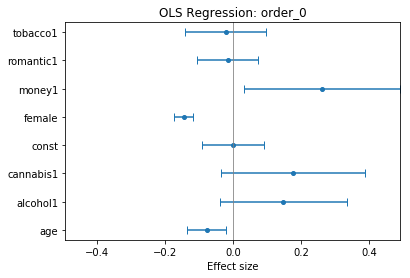

In [31]:
plot_behavior_ols(behavior, y_column="order_0", standardize=True, n_community=0)

### Short Answer Q6
In the single varaible correlation, alcohol use, cannabis use, and spending money were all significantly correlated with social status. Which of these remain significant in the mutliple regression above and which are no longer significant? Are there any variables that were not significant in the single variable correlations but became significant in the multiple regression?

####  Gender differences

In an early analysis of the TFLS data set, Mitchel and Amos found gendered differences in the relationship between smoking and social status [MA1997].
Specifically, when analyzing interviews with girls, they observed that high-status girls often discussed smoking, while low-status girls did not. However, when analyzing the transcripts of interviews with boys, they did not see a similar association.

The cells below performs a similar analysis based on the numerical questionnairre responses. The first line restricts the data to female participants, while the second line restricts the data to male participants.

Do you find a similar result?

In [32]:
status_correlation(behavior[behavior["female"] == 1], attributes=["tobacco1"])

Status ~ tobacco1         0.26	(p=0.0284)


In [33]:
status_correlation(behavior[behavior["female"] == 0], attributes=["tobacco1"])

Status ~ tobacco1         -0.10	(p=0.3700)


#### Gender differences: multiple regression

As before, any correlation with smoking may be confouded by other variables and we can control for confounds using a multiple regression. The following cell performs a multiple regression,
limiting the data to a single gender. Set the `female` variable to `1` for female or `0` for male. For each gender, consider these questions:

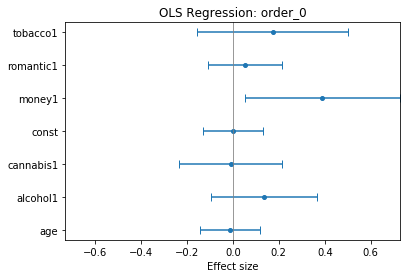

In [34]:
df = behavior[(behavior["female"] == 1)].dropna(how="any")
plot_behavior_ols(df, y_column="order_0", drop=["female"], standardize=True, n_community=0)

#### Gender differences: methods comparison
Do you see an effect for smoking that is significantly different from 0? Do you see an effect for any other variables? 

## Try it yourself

Following the methods above, perform a different analysis on the same data set. Here are some possibilities:
* [Switch to a different ranking method](#Choose-an-approximation-method) and perform the same analysis of gender, smoking, and social status. 
* Perform a [regression analysis](#Multiple-regression) of _change_ in status, gender, and substance use.

## Reflection Questions

1. Study participants were asked to name up to 12 friends. Friends who were not study participants were not recorded. Give two benefits and two drawbacks of this method for eliciting social networks? Can you think of another way to determine the friendship network of a group of people?

2. Even if we find significant correlations between variables like status and money, it's not possible to say that a varaible causes high status rather than the other way around. How might a higher social status cause an increase in the amount of spending money?

3. This lab has examined gender differences using two methods: Pearson correlation, and OLS multiple regression. The original authors used a qualitative analysis of interview transcripts. What were the similarities and differences between findings using different methods? Why might different methods show different findings? Can you reconcile these results? What are the benefits and drawbacks of each of these three types of analysis?

## References

[MA1997] L. Michell, and A. Amos, "Girls, pecking order and smoking." Social Science & Medicine 44(12), 1861-1869 (1997)

[BLN2013] De Bacco, C., Larremore, D. B., & Moore, C. (2017). A physical model for efficient ranking in networks. arXiv preprint arXiv:1709.09002.
